In [1]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo

In [2]:
Image(url='https://cdn-media-1.freecodecamp.org/images/3JXI06jyHegMS1Yx8rhIq64gkYwSTM7ZhD25')

* The robot loses 1 point at each step. This is done so that the robot takes the shortest path and reaches the goal as fast as possible.
* If the robot steps on a mine, the point loss is 100 and the game ends.
* If the robot gets power ⚡️, it gains 1 point.
* If the robot reaches the end goal, the robot gets 100 points.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random as rand
from collections import OrderedDict

# Rewards matrix

In [4]:
R = np.matrix(np.ones([5,6]))
R *= -1
R = pd.DataFrame(R)

In [5]:
R.iloc[0,2] = 1
R.iloc[1,1] = -100
R.iloc[1,4] = -100
R.iloc[2,2] = 1
R.iloc[2,5] = 1
R.iloc[3,0] = -100
R.iloc[3,3] = -100
R.iloc[4,1] = 1
R.iloc[4,4] = 100
R

,0,1,2,3,4,5
0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0
1,-1.0,-100.0,-1.0,-1.0,-100.0,-1.0
2,-1.0,-1.0,1.0,-1.0,-1.0,1.0
3,-100.0,-1.0,-1.0,-100.0,-1.0,-1.0
4,-1.0,1.0,-1.0,-1.0,100.0,-1.0


# Actions

In [6]:
A = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1)
}
A = OrderedDict(A)
A

OrderedDict([('up', (-1, 0)),
             ('down', (1, 0)),
             ('left', (0, -1)),
             ('right', (0, 1))])

# Q Matrix

In [7]:
Q = np.matrix(np.zeros([R.shape[0]*R.shape[1], len(A)]))
Q = pd.DataFrame(Q, 
                 index=pd.MultiIndex.from_tuples([(i, j) for i in range(R.shape[0]) for j in range(R.shape[1])]),
                columns=A.keys())
Q

up  down  left  right
0 0  0.0   0.0   0.0    0.0
  1  0.0   0.0   0.0    0.0
  2  0.0   0.0   0.0    0.0
  3  0.0   0.0   0.0    0.0
  4  0.0   0.0   0.0    0.0
  5  0.0   0.0   0.0    0.0
1 0  0.0   0.0   0.0    0.0
  1  0.0   0.0   0.0    0.0
  2  0.0   0.0   0.0    0.0
  3  0.0   0.0   0.0    0.0
  4  0.0   0.0   0.0    0.0
  5  0.0   0.0   0.0    0.0
2 0  0.0   0.0   0.0    0.0
  1  0.0   0.0   0.0    0.0
  2  0.0   0.0   0.0    0.0
  3  0.0   0.0   0.0    0.0
  4  0.0   0.0   0.0    0.0
  5  0.0   0.0   0.0    0.0
3 0  0.0   0.0   0.0    0.0
  1  0.0   0.0   0.0    0.0
  2  0.0   0.0   0.0    0.0
  3  0.0   0.0   0.0    0.0
  4  0.0   0.0   0.0    0.0
  5  0.0   0.0   0.0    0.0
4 0  0.0   0.0   0.0    0.0
  1  0.0   0.0   0.0    0.0
  2  0.0   0.0   0.0    0.0
  3  0.0   0.0   0.0    0.0
  4  0.0   0.0   0.0    0.0
  5  0.0   0.0   0.0    0.0

## Go to (row, column) expected reward

In [8]:
Q.loc[0,0]

up       0.0
down     0.0
left     0.0
right    0.0
Name: (0, 0), dtype: float64

# Learning parameter (gamma)
* between 0 and 1
* closer to 0: future rewards are not that important
* closer to 1: future rewards are very important

In [9]:
gamma = 0.5

# Available actions

In [10]:
def available_actions(state):
    actions = []
    for (key, value) in A.items():
        coords = (state[0] + value[0], state[1] + value[1])
        if coords in map(lambda r: r[0], np.ndenumerate(R)):
            actions.append(key)
    return actions

In [11]:
available_actions((0,0))

['down', 'right']

In [12]:
available_actions((4,5))

['up', 'left']

## Sample random action

In [13]:
def sample_next_action(available_actions_range):
    return rand.choice(available_actions_range)

In [14]:
actions_range = available_actions((4,5))
sample_next_action(actions_range)

'up'

In [15]:
def make_step(state, diff):
    return (state[0] + diff[0], state[1] + diff[1])

# Initial state

In [16]:
initial_state = (0,0)

In [17]:
actions = available_actions(initial_state)
actions

['down', 'right']

In [18]:
new_action = sample_next_action(actions)
new_action

'down'

## Update

In [19]:
def update(current_state, action, gamma):
    diff = A[action]
    new_state = make_step(current_state, diff)
    future_rewards = Q.loc[new_state]
    max_value = future_rewards.max()
    Q.loc[current_state][action] = R.loc[new_state] + gamma * max_value
#     Q.loc[current_state][action] = Q.loc[current_state][action] + alpha*(R.loc[new_state] + gamma * max_value - Q.loc[current_state][action])
    return new_state

In [20]:
update(initial_state, new_action, gamma)

(1, 0)

# Training

In [21]:
iterations = 500
max_steps = 200
all_steps = []

for i in range(iterations):
    epsilon = i/iterations
    print('epsilon: ', epsilon)
    
    state = initial_state # reset robot to original state
    
    done = False
    steps = 0
    while not done:
        possible_actions = available_actions(state)
        if rand.uniform(0, 1) > epsilon:
            action = sample_next_action(possible_actions) # Explore action space
        else:
            action = Q.loc[state].idxmax() # Exploitate state
            if action not in possible_actions:
                action = sample_next_action(possible_actions)

        new_state = update(state, action, gamma)
        print('new state: ', new_state)
        
        state = new_state
        steps += 1
        
        # check if it's done
        if state == (4,4):
            done = True
            print('==== END REACHED ====')
        if steps == max_steps:
            done = True
    all_steps.append(steps)

epsilon:  0.0
new state:  (1, 0)
new state:  (1, 1)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (1, 3)
new state:  (0, 3)
new state:  (1, 3)
new state:  (1, 4)
new state:  (1, 5)
new state:  (0, 5)
new state:  (1, 5)
new state:  (0, 5)
new state:  (1, 5)
new state:  (2, 5)
new state:  (1, 5)
new state:  (0, 5)
new state:  (1, 5)
new state:  (0, 5)
new state:  (0, 4)
new state:  (0, 3)
new state:  (0, 4)
new state:  (0, 5)
new state:  (0, 4)
new state:  (0, 5)
new state:  (1, 5)
new state:  (1, 4)
new state:  (0, 4)
new state:  (1, 4)
new state:  (0, 4)
new state:  (0, 5)
new state:  (1, 5)
new state:  (0, 5)
new state:  (1, 5)
new state:  (1, 4)
new state:  (2, 4)
new state:  (1, 4)
new state:  (1, 3)
new state:  (1, 4)
new state:  (1, 5)
new state:  (1, 4)
new state:  (0, 4)
new state:  (0, 3)
new state:  (0, 2)
new state:  (0, 3)
new state:  (0, 4)
new state:  (0, 3)
new state:  (0, 2)
new state:  (0, 3)
new state:  (1, 3)
new state:  (1, 2)
new state:  (1, 3

new state:  (4, 2)
new state:  (3, 2)
new state:  (2, 2)
new state:  (1, 2)
new state:  (0, 2)
new state:  (1, 2)
new state:  (1, 3)
new state:  (0, 3)
new state:  (0, 4)
new state:  (0, 5)
new state:  (0, 4)
new state:  (1, 4)
new state:  (1, 3)
new state:  (2, 3)
new state:  (2, 4)
new state:  (3, 4)
new state:  (3, 5)
new state:  (4, 5)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.008
new state:  (1, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (3, 1)
new state:  (3, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (1, 1)
new state:  (0, 1)
new state:  (1, 1)
new state:  (0, 1)
new state:  (0, 0)
new state:  (0, 1)
new state:  (1, 1)
new state:  (1, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (1, 1)
new state:  (1, 0)
new state:  (2, 0)
new state:  (3, 0)
new state:  (3, 1)
new state:  (2, 1)
new state:  (3, 1)
new state:  (3, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  

new state:  (4, 4)
==== END REACHED ====
epsilon:  0.024
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (2, 1)
new state:  (3, 1)
new state:  (3, 2)
new state:  (3, 3)
new state:  (2, 3)
new state:  (3, 3)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.026
new state:  (0, 1)
new state:  (0, 0)
new state:  (1, 0)
new state:  (1, 1)
new state:  (0, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (3, 1)
new state:  (3, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (3, 3)
new state:  (2, 3)
new state:  (1, 3)
new state:  (1, 4)
new state:  (1, 3)
new state:  (1, 4)
new state:  (2, 4)
new state:  (2, 3)
new state:  (2, 4)
new state:  (2, 3)
new state:  (3, 3)
new state:  (3, 2)
new state:  (3, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (3, 2)
new state:  (3, 1)
new state:  (4, 1)
new state:  (3, 1)
new state:  (3, 0)
new state:  (2, 0)
new state:  (1, 0)
new state:  

epsilon:  0.046
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (0, 2)
new state:  (1, 2)
new state:  (0, 2)
new state:  (0, 3)
new state:  (0, 4)
new state:  (0, 5)
new state:  (0, 4)
new state:  (1, 4)
new state:  (1, 3)
new state:  (1, 4)
new state:  (0, 4)
new state:  (0, 3)
new state:  (0, 4)
new state:  (1, 4)
new state:  (1, 5)
new state:  (0, 5)
new state:  (0, 4)
new state:  (0, 5)
new state:  (0, 4)
new state:  (0, 5)
new state:  (1, 5)
new state:  (0, 5)
new state:  (1, 5)
new state:  (1, 4)
new state:  (1, 5)
new state:  (2, 5)
new state:  (3, 5)
new state:  (2, 5)
new state:  (1, 5)
new state:  (0, 5)
new state:  (0, 4)
new state:  (0, 5)
new state:  (1, 5)
new state:  (2, 5)
new state:  (2, 4)
new state:  (2, 5)
new state:  (1, 5)
new state:  (1, 4)
new state:  (1, 5)
new state:  (0, 5)
new state:  (0, 4)
new state:  (1, 4)
new state:  (0, 4)
new state:  (0, 3)
new state:  (0, 4)
new state:  (1, 4)
new state:  (0, 4)
new state:  (0, 5)
new state:  (0,

new state:  (3, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (1, 1)
new state:  (0, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (3, 1)
new state:  (3, 2)
new state:  (2, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (2, 3)
new state:  (2, 2)
new state:  (2, 1)
new state:  (1, 1)
new state:  (1, 0)
new state:  (0, 0)
new state:  (1, 0)
new state:  (0, 0)
new state:  (0, 1)
new state:  (0, 0)
new state:  (1, 0)
new state:  (2, 0)
new state:  (1, 0)
new state:  (0, 0)
new state:  (0, 1)
new state:  (0, 0)
new state:  (0, 1)
new state:  (1, 1)
new state:  (1, 0)
new state:  (1, 1)
new state:  (2, 1)
new state:  (2, 0)
new state:  (1, 0)
new state:  (1, 1)
new state:  (2, 1)
new state:  (3, 1)
new state:  (2, 1)
new state:  (2, 0)
new state:  (1, 0)
new state:  (0, 0)
new state:  (1, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 0)
new state:  (1, 0)
new state:  (1, 1)
new state:  (0, 1)
new state:  (1, 1)
new state:  (0, 1)
new state:  (0, 0)
new state:  

new state:  (1, 0)
new state:  (0, 0)
new state:  (0, 1)
new state:  (0, 0)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (1, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (3, 2)
new state:  (3, 1)
new state:  (2, 1)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 0)
new state:  (1, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 2)
new state:  (1, 2)
new state:  (1, 1)
new state:  (1, 2)
new state:  (0, 2)
new state:  (0, 1)
new state:  (1, 1)
new state:  (1, 2)
new state:  (2, 2)
new state:  (1, 2)
new state:  (0, 2)
new state:  (0, 1)
new state:  (0, 2)
new state:  (0, 3)
new state:  (0, 2)
new state:  (0, 1)
new state:  (0, 2)
new state:  (0, 3)
new state:  (0, 2)
new state:  (0, 3)
new state:  (1, 3)
new state:  (2, 3)
new state:  (1, 3)
new state:  (0, 3)
new state:  (1, 3)
new state:  (0, 3)
new state:  (1, 3)
new state:  (1, 2)
new state:  (1, 1)
new state:  (1, 2)
new state:  (2, 2)
new state:  

new state:  (1, 0)
new state:  (1, 1)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 1)
new state:  (3, 1)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 3)
new state:  (3, 3)
new state:  (2, 3)
new state:  (3, 3)
new state:  (3, 4)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.09
new state:  (0, 1)
new state:  (0, 0)
new state:  (1, 0)
new state:  (1, 1)
new state:  (2, 1)
new state:  (3, 1)
new state:  (3, 2)
new state:  (3, 3)
new state:  (2, 3)
new state:  (3, 3)
new state:  (2, 3)
new state:  (2, 4)
new state:  (1, 4)
new state:  (0, 4)
new state:  (0, 3)
new state:  (1, 3)
new state:  (0, 3)
new state:  (1, 3)
new state:  (2, 3)
new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.092
new state:  (1, 0)
new state:  (2, 0)
new state:  (1, 0)
new state:  (0, 0)
new state:  (0, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (2, 0)
new state:  (

new state:  (4, 2)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 1)
new state:  (3, 1)
new state:  (4, 1)
new state:  (4, 0)
new state:  (3, 0)
new state:  (3, 1)
new state:  (2, 1)
new state:  (3, 1)
new state:  (3, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 3)
new state:  (2, 4)
new state:  (3, 4)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.108
new state:  (0, 1)
new state:  (1, 1)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (2, 1)
new state:  (1, 1)
new state:  (1, 2)
new state:  (1, 1)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 1)
new state:  (3, 1)
new state:  (2, 1)
new state:  (1, 1)
new state:  (1, 2)
new state:  (1, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (3, 2)
new state:  (3, 3)
new state:  (3, 4)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.11
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (

new state:  (4, 2)
new state:  (4, 1)
new state:  (4, 0)
new state:  (4, 1)
new state:  (4, 0)
new state:  (3, 0)
new state:  (3, 1)
new state:  (3, 2)
new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 2)
new state:  (3, 2)
new state:  (2, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (1, 2)
new state:  (0, 2)
new state:  (0, 3)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (2, 3)
new state:  (3, 3)
new state:  (3, 2)
new state:  (3, 1)
new state:  (4, 1)
new state:  (3, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 1)
new state:  (3, 1)
new state:  (3, 0)
new state:  (3, 1)
new state:  (3, 0)
new state:  (3, 1)
new state:  (3, 0)
new state:  (4, 0)
new state:  (4, 1)
new state:  (4, 0)
new state:  (4, 1)
new state:  (3, 1)
new state:  (3, 2)
new state:  (3, 3)
new state:  (2, 3)
new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.136
new state:  (1, 0)
new state:  (0, 0)
new state:  (1, 0)
new state:  

new state:  (2, 3)
new state:  (3, 3)
new state:  (3, 4)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.162
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (2, 3)
new state:  (1, 3)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 1)
new state:  (4, 0)
new state:  (3, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 1)
new state:  (3, 1)
new state:  (4, 1)
new state:  (4, 0)
new state:  (3, 0)
new state:  (3, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 3)
new state:  (2, 4)
new state:  (2, 5)
new state:  (1, 5)
new state:  (1, 4)
new state:  (1, 3)
new state:  (1, 2)
new state:  (1, 1)
new state:  (0, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 3)
new state:  (3, 3)
new state:  (2, 3)
new state:  (3, 3)
new state:  (3, 2)
new state:  (3, 3)
new state:  (3, 2)
new state:  (3, 3)
new state:  (3, 4)
new state:  (3, 5)
new state:  

new state:  (0, 3)
new state:  (1, 3)
new state:  (2, 3)
new state:  (1, 3)
new state:  (2, 3)
new state:  (3, 3)
new state:  (3, 4)
new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.19
new state:  (1, 0)
new state:  (2, 0)
new state:  (1, 0)
new state:  (0, 0)
new state:  (1, 0)
new state:  (2, 0)
new state:  (3, 0)
new state:  (3, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (3, 2)
new state:  (3, 1)
new state:  (3, 0)
new state:  (4, 0)
new state:  (4, 1)
new state:  (4, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (3, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.192
new state:  (0, 1)
new state:  (0, 2)
new state:  (0, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 1)
new state:  (3, 1)
new state:  (3, 0)
new state:  (4, 0)
new state:  (4, 1)
new state:  (3, 1)
new state:  (

new state:  (3, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (2, 3)
new state:  (2, 2)
new state:  (3, 2)
new state:  (3, 1)
new state:  (4, 1)
new state:  (3, 1)
new state:  (3, 2)
new state:  (2, 2)
new state:  (2, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (3, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 3)
new state:  (1, 3)
new state:  (1, 2)
new state:  (0, 2)
new state:  (1, 2)
new state:  (1, 1)
new state:  (2, 1)
new state:  (2, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (2, 3)
new state:  (2, 4)
new state:  (2, 5)
new state:  (3, 5)
new state:  (3, 4)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.226
new state:  (0, 1)
new state:  (0, 2)
new state:  (0, 3)
new state:  (1, 3)
new state:  (2, 3)
new state:  (2, 2)
new state:  (2, 3)
new state:  (2, 2)
new state:  (2, 1)
new state:  (3, 1)
new state:  (4, 1)
new state:  (3, 1)
new state:  (4, 1)
new state:  

new state:  (3, 1)
new state:  (2, 1)
new state:  (3, 1)
new state:  (4, 1)
new state:  (4, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (3, 2)
new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.246
new state:  (0, 1)
new state:  (1, 1)
new state:  (0, 1)
new state:  (1, 1)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (3, 2)
new state:  (3, 1)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.248
new state:  (0, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (3, 1)
new state:  (4, 1)
new state:  (4, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 2)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 3)
new state:  (3, 3)
new state:  (3, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  

new state:  (0, 2)
new state:  (1, 2)
new state:  (1, 1)
new state:  (1, 0)
new state:  (2, 0)
new state:  (3, 0)
new state:  (4, 0)
new state:  (3, 0)
new state:  (4, 0)
new state:  (3, 0)
new state:  (4, 0)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 2)
new state:  (4, 3)
new state:  (3, 3)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.298
new state:  (1, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 0)
new state:  (1, 0)
new state:  (2, 0)
new state:  (3, 0)
new state:  (4, 0)
new state:  (3, 0)
new state:  (4, 0)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.3
new state:  (0, 1)
new state:  (1, 1)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 1)
new state:  (4, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (3, 2)
new state:  (3, 3)
new state:  (4, 3)
new state:  (3

new state:  (0, 1)
new state:  (0, 2)
new state:  (0, 3)
new state:  (0, 2)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (1, 3)
new state:  (2, 3)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.354
new state:  (1, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 3)
new state:  (2, 2)
new state:  (3, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.356
new state:  (0, 1)
new state:  (0, 2)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.358
new state:  (1, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  

new state:  (3, 1)
new state:  (4, 1)
new state:  (4, 2)
new state:  (3, 2)
new state:  (3, 3)
new state:  (3, 4)
new state:  (2, 4)
new state:  (1, 4)
new state:  (1, 3)
new state:  (2, 3)
new state:  (1, 3)
new state:  (1, 4)
new state:  (1, 3)
new state:  (0, 3)
new state:  (1, 3)
new state:  (2, 3)
new state:  (2, 4)
new state:  (1, 4)
new state:  (0, 4)
new state:  (0, 5)
new state:  (0, 4)
new state:  (0, 3)
new state:  (1, 3)
new state:  (1, 2)
new state:  (1, 3)
new state:  (2, 3)
new state:  (2, 4)
new state:  (3, 4)
new state:  (3, 5)
new state:  (2, 5)
new state:  (1, 5)
new state:  (2, 5)
new state:  (3, 5)
new state:  (4, 5)
new state:  (3, 5)
new state:  (3, 4)
new state:  (3, 5)
new state:  (2, 5)
new state:  (2, 4)
new state:  (2, 5)
new state:  (3, 5)
new state:  (4, 5)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.4
new state:  (0, 1)
new state:  (1, 1)
new state:  (0, 1)
new state:  (1, 1)
new state:  (0, 1)
new state:  (1, 1)
new state:  (2, 1)
new state:  (3

new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.446
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (1, 3)
new state:  (2, 3)
new state:  (2, 4)
new state:  (3, 4)
new state:  (3, 5)
new state:  (4, 5)
new state:  (3, 5)
new state:  (4, 5)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.448
new state:  (0, 1)
new state:  (0, 2)
new state:  (0, 3)
new state:  (1, 3)
new state:  (0, 3)
new state:  (0, 2)
new state:  (0, 3)
new state:  (0, 2)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (2, 3)
new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.45
new state:  (1, 0)
new state:  (0, 0)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  

new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (1, 3)
new state:  (2, 3)
new state:  (3, 3)
new state:  (4, 3)
new state:  (3, 3)
new state:  (3, 4)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.512
new state:  (0, 1)
new state:  (0, 2)
new state:  (0, 3)
new state:  (1, 3)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.514
new state:  (1, 0)
new state:  (2, 0)
new state:  (3, 0)
new state:  (4, 0)
new state:  (3, 0)
new state:  (4, 0)
new state:  (4, 1)
new state:  (4, 2)
new state:  (3, 2)
new state:  (3, 3)
new state:  (3, 2)
new state:  (3, 1)
new state:  (3, 0)
new state:  (2, 0)
new state:  (3, 0)
new state:  (4, 0)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.516
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  

new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 1)
new state:  (3, 1)
new state:  (4, 1)
new state:  (3, 1)
new state:  (4, 1)
new state:  (4, 0)
new state:  (3, 0)
new state:  (4, 0)
new state:  (4, 1)
new state:  (4, 0)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 1)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.574
new state:  (0, 1)
new state:  (0, 2)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (0, 2)
new state:  (0, 3)
new state:  (1, 3)
new state:  (1, 4)
new state:  (2, 4)
new state:  (2, 3)
new state:  (2, 4)
new state:  (2, 5)
new state:  (2, 4)
new state:  (2, 5)
new state:  (3, 5)
new state:  (4, 5)
new state:  (3, 5)
new state:  (2, 5)
new state:  (1, 5)
new state:  (2, 5)
new state:  (3, 5)
new state:  (4, 5)
new state:  (3, 5)
new state:  (4, 5)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.576
new state:  (0, 1)
new state:  (1, 1)
new state:  (1, 2)
new state:  (0, 2)
new state:  

new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (2, 2)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 3)
new state:  (2, 4)
new state:  (2, 5)
new state:  (3, 5)
new state:  (4, 5)
new state:  (3, 5)
new state:  (4, 5)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.65
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (1, 1)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.652
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.654
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (3, 1)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  

epsilon:  0.738
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (1, 3)
new state:  (2, 3)
new state:  (2, 4)
new state:  (3, 4)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.74
new state:  (1, 0)
new state:  (2, 0)
new state:  (2, 1)
new state:  (2, 2)
new state:  (2, 1)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.742
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.744
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.746
new state:  (0, 1)
new state:  (0, 2)
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (3, 

new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.812
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.814
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.816
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (3, 3)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.818
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon: 

new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.92
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.922
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.924
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.926
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (2, 2)
new state:  (3, 2)
new state:  (4, 2)
new state:  (4, 3)
new state:  (4, 4)
==== END REACHED ====
epsilon:  0.928
new state:  (0, 1)
new state:  (0, 2)
new state:  (1, 2)
new state:  (

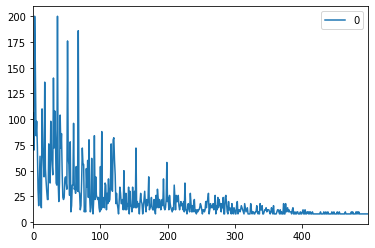

In [22]:
pd.DataFrame(all_steps).plot()

In [23]:
Q

up        down        left       right
0 0   0.000000   -0.953125    0.000000    0.046875
  1   0.000000  -98.906250   -0.976562    2.093750
  2   0.000000    2.187500    0.046875    1.187500
  3   0.000000    4.375000    2.093750   -0.156250
  4   0.000000  -88.250000    1.187500    1.687500
  5   0.000000    5.375000   -0.156250    0.000000
1 0  -0.976562    0.093750    0.000000  -98.906250
  1   0.046875    2.187500   -0.953125    2.187500
  2   2.093750    6.375000  -98.906250    4.375000
  3   1.187500   10.750000    2.187500  -88.250000
  4  -0.156250   23.500000    4.375000    5.375000
  5   1.687500   12.750000  -88.250000    0.000000
2 0  -0.953125  -97.312500    0.000000    2.187500
  1 -98.906250    5.375000    0.093750    6.375000
  2   2.187500   10.750000    2.187500   10.750000
  3   4.375000  -75.500000    6.375000   23.500000
  4 -88.250000   49.000000   10.750000   12.750000
  5   5.375000   23.500000   23.500000    0.000000
3 0   0.093750    5.375000    0.000000    5.375000
  1   2.187500   12.750000  -97.312500   10.750000
  2   6.375000   23.500000    5.375000  -75.500000
  3  10.750000   49.000000   10.750000   49.000000
  4  23.500000  100.000000  -75.500000   23.500000
  5  12.750000   49.000000   49.000000    0.000000
4 0 -97.312500    0.000000    0.000000   12.750000
  1   5.375000    0.000000    5.375000   23.500000
  2  10.750000    0.000000   12.750000   49.000000
  3 -75.500000    0.000000   23.500000  100.000000
  4   0.000000    0.000000    0.000000    0.000000
  5  23.500000    0.000000  100.000000    0.000000